#### Wesleyan University ASTR 221

## Tutorial 4: Splines

So far, we have covered nearest-neighbor and linear interpolation schemes, which are the simplest and second-simplest ways to interpolate.  This time, we'll use a slightly more sophisticated technique called a **spline**: defining a unique function for each interval $(x_i, y_i)$ to $(x_{i+1}, y_{i+1})$, and using continuity and smoothness conditions to stitch them together.  (Nearest-neighbor and linear interpolations are actually 0th- and 1st-order splines too.)

In addition to the packages from before, we now import scipy's linear algebra package:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120  
from math import pi
from scipy.interpolate import interp1d
from scipy import linalg

Here is our sine wave sampled every $\pi/4$ radians:

Text(0, 0.5, 'y')

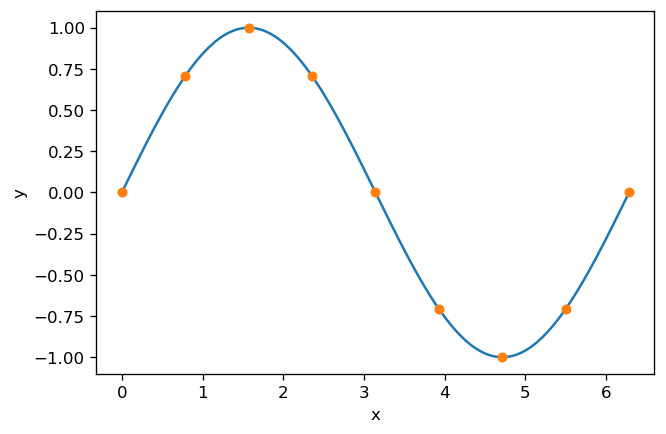

In [2]:
# Construct array of equally-spaced grid points
xmin = 0.
xmax = 2*pi
dx = pi/4.
ncells = int((xmax - xmin)/dx)
dx = (xmax - xmin)/ncells   # For consistency, just in case it didn't go in evenly

# Sample points
x = np.linspace(xmin, xmax, ncells+1)
y = np.sin(x)

# Make a very high-resolution x-grid to show the underlying sine curve
x_hr = np.linspace(xmin, xmax, 200)
y_hr = np.sin(x_hr)

fig, ax = plt.subplots()
plt.plot(x_hr,y_hr, '-')
plt.plot(x, y, 'o', ms=5)
ax.set_xlabel('x')
ax.set_ylabel('y')

Remember that we could, in theory, construct a parabola for each set of 3 points.  Here's an example for the first three:

(-2.0, 1.5)

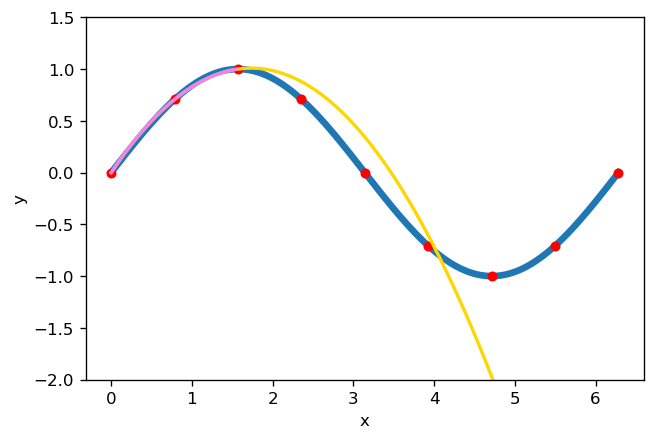

In [3]:
# Define parabola for first 3 sample points
A = (y[0] - 2*y[1] + y[2])/(2*dx**2)
B = (-3*y[0] + 4*y[1] - y[2])/(2*dx)
C = y[0]

y_quad = A*(x_hr-x[0])**2 + B*(x_hr - x[0]) + C

fig, ax = plt.subplots()
plt.plot(x_hr,y_hr, '-', lw=4)
plt.plot(x, y, 'o', ms=5, color='red')
plt.plot(x_hr, y_quad, '-', color='gold', lw=2)
plt.plot(x_hr[x_hr < x[2]], y_quad[x_hr < x[2]], '-', color='violet', lw=2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_ylim(-2, 1.5)

This works great for the first three points, following the sine curve pretty closely.  As with the linear interpolation, we can repeat this for every set of 3 points:

(-1.2, 1.2)

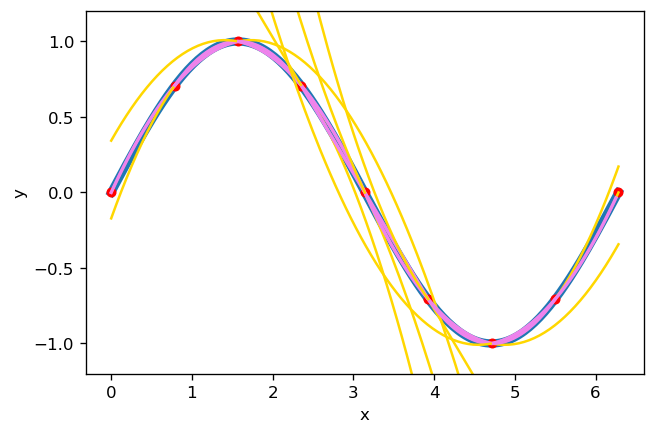

In [4]:
fig, ax = plt.subplots()
plt.plot(x_hr,y_hr, '-', lw=5)
plt.plot(x, y, 'o', ms=5, color='red')
ax.set_xlabel('x')
ax.set_ylabel('y')

# Loop over points
for i in range(len(x)-2):
    # Define the endpoints
    x0 = x[i]
    x1 = x[i+1]
    x2 = x[i+2]
    y0 = y[i]
    y1 = y[i+1]
    y2 = y[i+2]

    A = (y0 - 2*y1 + y2)/(2*dx**2)
    B = (-3*y0 + 4*y1 - y2)/(2*dx)
    C = y0

    y_quad = A*(x_hr-x0)**2 + B*(x_hr - x0) + C

    # Plot entire parabola in gold
    plt.plot(x_hr, y_quad, '-', color='gold')
    
    # Replot only the points in the three-point range in violet
    inrange = (x_hr >= x0) & (x_hr < x2)
    plt.plot(x_hr[inrange], y_quad[inrange], '-', color='violet', lw=2)
    
ax.set_ylim(-1.2, 1.2)

These work pretty well, but it is awkward to think about how to stitch them together into one function.  Instead of using three-point intervals to get enough equations to solve for the quadratic coefficients, we can use two-point intervals and impose constraints on *continuity* and *smoothness*, i.e. require the first derivatives to be the same at all the endpoints.

For a set of three points, we will have two quadratic functions $a_1 x^2 + b_1 x + c_1$ (on the interval $[x_1, x_2]$) and $a_2 x^2 + b_2 x + c_2$ (on the interval $[x_2, x_3]$), with six coefficients in total to solve for.  The endpoints give us four equations,
$$ y_1 = a_1 x_1^2 + b_1 x_1 + c_1 $$
$$ y_2 = a_1 x_2^2 + b_1 x_2 + c_1 $$
$$ y_2 = a_2 x_2^2 + b_2 x_2 + c_2 $$
$$ y_3 = a_2 x_3^2 + b_2 x_3 + c_2 $$
and we can gain another equation by requiring the first derivative to be continuous at $x_2$,
$$ 2 a_1 x_2 + b_1 = 2 a_2 x_2 + b_2. $$
Finally, we can get a sixth equation by requiring the function to be linear at $x_1$ (i.e., with a second derivative of 0), meaning
$$ a_1 = 0. $$

If we put this into matrix form, we have
\begin{equation}
\begin{bmatrix}
x_1^2 & x_1 & 1 & 0 & 0 & 0 \\
x_2^2 & x_2 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & x_2^2 & x_2 & 1 \\
0 & 0 & 0 & x_3^2 & x_3 & 1 \\
2 x_2 & 1 & 0 & -2 x_2 & -1 & 0 \\
1 & 0 & 0 & 0 & 0 & 0 
\end{bmatrix} 
\begin{bmatrix}
a_1 \\
b_1 \\
c_1 \\
a_2 \\
b_2 \\
c_2 
\end{bmatrix}
=
\begin{bmatrix}
y_1 \\
y_2 \\
y_2 \\
y_3 \\
0 \\
0 
\end{bmatrix}
\end{equation}

To solve for our six coefficients, all we need to do is invert this matrix.

In [5]:
# Define the matrix as above
spline_matrix = np.array([  [x[0]**2, x[0] , 1 , 0 , 0 , 0],
                            [x[1]**2 , x[1] , 1 , 0 , 0 , 0],
                            [0 , 0 , 0 , x[1]**2 , x[1] , 1],
                            [0 , 0 , 0 , x[2]**2 , x[2] , 1],
                            [2*x[1] , 1 , 0 , -2*x[1] , -1 , 0],
                            [1 , 0 , 0 , 0 , 0 , 0] ])

# Invert matrix using scipy's linear algebra package
matrix_inverted = linalg.inv(spline_matrix)

# Check to see that the matrix was correctly inverted
np.round(spline_matrix.dot(matrix_inverted), decimals = 3)

array([[ 1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.],
       [ 0., -0.,  1.,  0.,  0.,  0.],
       [ 0., -0., -0.,  1.,  0., -0.],
       [-0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.]])

We got the identity matrix (modulo machine precision) back out when we multiply the matrix by its inverse, so that's good!  Note that matrix multiplication is **not** the same thing as numpy array multiplication - the latter will multiply all the elements pairwise:

In [6]:
np.round(spline_matrix * matrix_inverted, decimals = 3)

array([[ 0.   ,  0.   , -0.   ,  0.   ,  0.   ,  0.   ],
       [-0.785,  1.   , -0.   ,  0.   ,  0.   , -0.   ],
       [ 0.   ,  0.   , -0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.   , -0.   , -0.   ,  4.   ,  2.   , -1.   ],
       [-6.   ,  3.82 ,  0.   ,  4.   ,  3.   ,  0.   ],
       [ 2.   , -0.   ,  0.   ,  0.   ,  0.   , -0.   ]])

Now we can multiply the inverted matrix by the array of $y$-values on the right to find our coefficients:

In [7]:
quad_coeff = matrix_inverted.dot(np.array([y[0], y[1], y[1], y[2], 0, 0]))
print(quad_coeff)

[ 0.          0.90031632  0.         -0.67149773  1.95510249 -0.41421356]


It is a good sanity check that $a_1 = 0$ as we expect!  Finally, let's use these coefficients to construct our two quadratic functions:

(-1.2, 1.2)

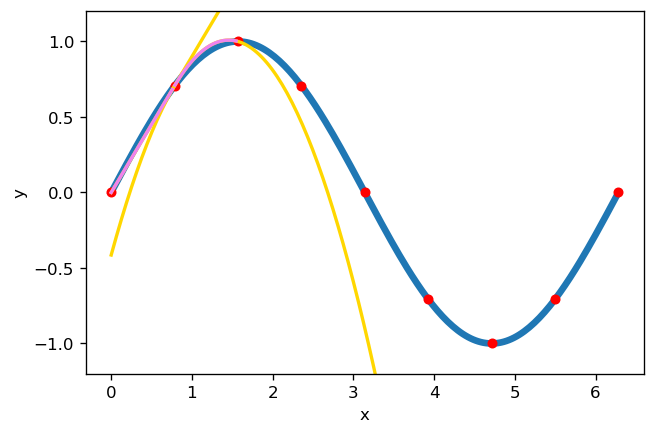

In [8]:
# Retrieve coefficients from matrix
a1 = quad_coeff[0]
b1 = quad_coeff[1]
c1 = quad_coeff[2]
a2 = quad_coeff[3]
b2 = quad_coeff[4]
c2 = quad_coeff[5]

y_quad_1 = a1*x_hr**2 + b1*x_hr + c1
y_quad_2 = a2*x_hr**2 + b2*x_hr + c2

fig, ax = plt.subplots()
plt.plot(x_hr,y_hr, '-', lw=4)
plt.plot(x, y, 'o', ms=5, color='red')

# Plot full parabolas in gold
plt.plot(x_hr, y_quad_1, '-', color='gold', lw=2)
plt.plot(x_hr, y_quad_2, '-', color='gold', lw=2)

# Replot only the points in the relevant intervals in violet
inrange = (x_hr >= x[0]) & (x_hr < x[1])
plt.plot(x_hr[inrange], y_quad_1[inrange], '-', color='violet', lw=2)
inrange = (x_hr >= x[1]) & (x_hr < x[2])
plt.plot(x_hr[inrange], y_quad_2[inrange], '-', color='violet', lw=2)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_ylim(-1.2, 1.2)

Great!  Now we have a unique quadratic function defined for each of the first two intervals, but they connect smoothly and continuously.  

Finally, let's extend what we just wrote to the complete set of points.  Because there are 9 points, there will be $(9-1) \times 3 = 24$ coefficients, and 24 equations.  Let's construct our matrix such that the first 8 equations represent the left endpoints, the next 8 represent the right endpoints, the next 7 represent the first derivative constraints, and the last one is $a_1 = 0$.  

In [9]:
# Declare a variable for the number of intervals, for generality
nint = len(x)-1

# Initialize matrix
spline_matrix = np.zeros([nint*3, nint*3])

# Loop over intervals
for i in range(nint):
    # Left endpoint equation
    spline_matrix[i,i*3] = x[i]**2   # a_i
    spline_matrix[i,i*3+1] = x[i]    # b_i
    spline_matrix[i,i*3+2] = 1       # c_i
    
    # Right endpoint equation
    spline_matrix[nint+i,i*3] = x[i+1]**2  # a_i
    spline_matrix[nint+i,i*3+1] = x[i+1]   # b_i
    spline_matrix[nint+i,i*3+2] = 1        # c_i
    
    # First derivative constraint
    if i != nint-1:  # Don't do this for the final interval
        spline_matrix[2*nint+i,i*3] = 2*x[i+1]      # a_i
        spline_matrix[2*nint+i,i*3+1] = 1           # b_i
        spline_matrix[2*nint+i,(i+1)*3] = -2*x[i+1] # a_{i+1}
        spline_matrix[2*nint+i,(i+1)*3+1] = -1      # b_{i+1}
        
# Set leftmost endpoint to be linear
spline_matrix[nint*3-1,0] = 1

Now we can proceed with the matrix inversion just as before.  First, we need to construct the array of y-values on the right-hand side of the equation.  Because we put the left endpoint equations first, then the right endpoint equations, the first 8 elements should be the left endpoints ```y[:-1]```, the next 8 should be the right endpoints ```y[1:]```, and the rest will be zeros for the first derivative constraints and the $a_1 = 0$ constraint.

In [10]:
# Invert matrix using scipy's linear algebra package
matrix_inverted = linalg.inv(spline_matrix)

# Matrix multiply with array of y-values
y_arr = np.zeros(nint*3)
y_arr[:nint] = y[:-1]  # Left endpoints
y_arr[nint:2*nint] = y[1:]  # Right endpoints
quad_coeff = matrix_inverted.dot(y_arr)

Let's take a look at what we got!

(-1.2, 1.2)

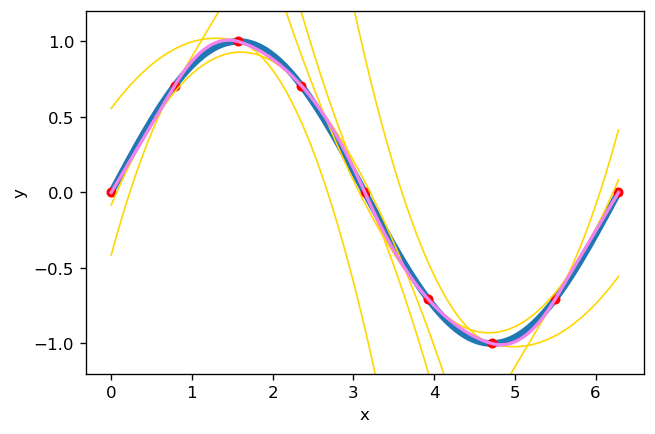

In [11]:
y_quad_spline = x_hr*0.

fig, ax = plt.subplots()
plt.plot(x_hr,y_hr, '-', lw=4)
plt.plot(x, y, 'o', ms=5, color='red')

for i in range(nint):
    # Retrieve coefficients from matrix
    a = quad_coeff[i*3]
    b = quad_coeff[i*3+1]
    c = quad_coeff[i*3+2]

    y_quad = a*x_hr**2 + b*x_hr + c

    # Plot full parabola in gold
    plt.plot(x_hr, y_quad, '-', color='gold', lw=1)

    # Save relevant interval
    inrange = (x_hr >= x[i]) & (x_hr <= x[i+1])
    y_quad_spline[inrange] = y_quad[inrange]
    
plt.plot(x_hr, y_quad_spline, '-', color='violet', lw=2)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_ylim(-1.2, 1.2)

It's not perfect, but it is smooth, continuous, and overall a pretty good approximation to the underlying function.  Let's see how it compares to scipy's version:

In [12]:
# Create quadratic spline interpolation function from our (x,y) points
f_quad = interp1d(x,y, kind='quadratic')

# Use the function to interpolate y-values from our high-resolution array of x-values
y_fquad = f_quad(x_hr)

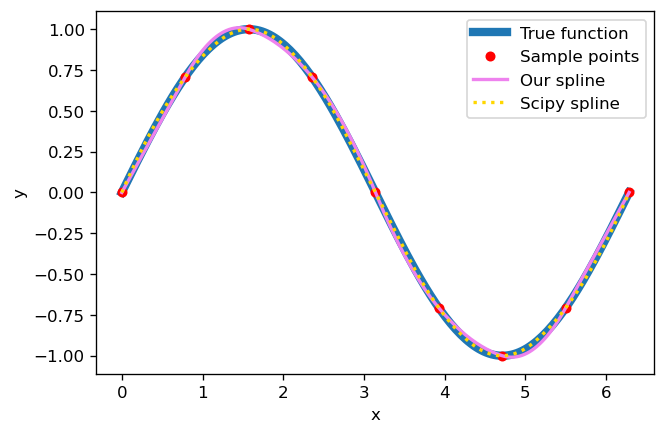

In [13]:
fig, ax = plt.subplots()
plt.plot(x_hr,y_hr, '-', lw=5)
plt.plot(x, y, 'o', ms=5, color='red')
plt.plot(x_hr, y_quad_spline, '-', lw=2, color='violet')
plt.plot(x_hr, y_fquad, ':', color='gold', lw=2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(['True function', 'Sample points', 'Our spline', 'Scipy spline'])

In this case, you can see that our spline is not identical to the one we got from ```interp1d```.  I dug into the source code, and it turns out that this is because they use a different final constraint.  Rather than requiring the function to be linear at one end, they require the spline functions in the first two intervals to be identical.  Apparently, this results in a nicer solution (for this case, at least)!

## Cubic splines

One step up in "niceness" from a quadratic spline is, of course, a cubic spline!  This has four coefficients per interval,
$$ y = a_i x^3 + b_i x^2 + c_i x + d_i. $$

Having an extra coefficient in each interval means that there are $n_{\rm int}$ more parameters to solve for, so we need more equations.  For a cubic spline, we therefore require a continuous *second* derivative at the sample points, in addition to a continuous first derivative.  This gets us $n_{\rm int} - 1$ more equations.  To pick up the last one, we can (for example) impose linearity on the other endpoint at $x_n$.

The requirement of having a second derivative of zero at the endpoints is called a "natural" spline.  One could instead impose a requirement that the first derivative be zero (a "clamped" spline).  In this particular case, where we know (or suspect) the function to be periodic, we could also choose to require the values and derivatives at the endpoints be identical.  And of course, it seems that scipy's default behavior is something slightly more complicated, to require that the first and second segments have the same polynomial.

The quadratic spline already did quite a nice job at reproducing the simple sine curve, so let's try something a little more complicated:

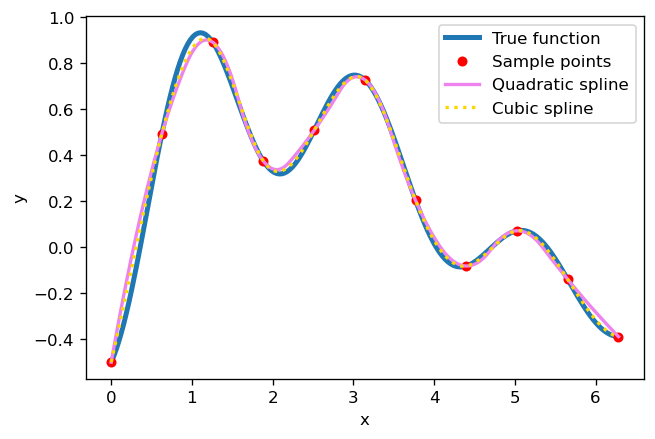

In [14]:
ncells = 10
dx = (xmax - xmin)/ncells 
x = np.linspace(xmin, xmax, ncells+1)

y_complex = np.exp(-x_hr/5)*(np.sin(x_hr/1.5) - np.cos(x_hr*3)/2)
y_sample = np.exp(-x/5)*(np.sin(x/1.5) - np.cos(x*3)/2)

f_quad = interp1d(x,y_sample, kind='quadratic')
f_cubic = interp1d(x,y_sample, kind='cubic')

y_qinterp = f_quad(x_hr)
y_cinterp = f_cubic(x_hr)

fig, ax = plt.subplots()
plt.plot(x_hr,y_complex, '-', lw=3)
plt.plot(x, y_sample, 'o', ms=5, color='red')
plt.plot(x_hr, y_qinterp, '-', lw=2, color='violet')
plt.plot(x_hr, y_cinterp, ':', color='gold', lw=2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(['True function', 'Sample points', 'Quadratic spline', 'Cubic spline'])

What we gain in "niceness" from increasing the order of the polynomial, we lose in computational efficiency.  At baseline, matrix operations are pretty fast, but matrix inversion scales as $O(n^{2-3})$ depending on the algorithm and the properties of the matrix.  So at some point, increasing the order of the spline becomes no longer worth it as the size of the matrix you need to invert grows and grows.  For most purposes, a cubic spline is the place where that balance lies; it becomes counter-productive to move to higher-order polynomials.  As a result, most spline interpolation functions will default to a cubic spline unless you specify otherwise.